In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KernelDensity
from tqdm import tqdm

In [4]:
def run_simulation(n_runs):
    def create_results_folder():
        
        if not os.path.exists("../files/results"):
            os.makedirs("../files/results")
            
    def generate_data():
        
        X, y = make_regression(
            n_samples=100, 
            n_features=3, 
            noise=0.1, 
            random_state=42
            )
        
        df = pd.DataFrame(X, columns=['x1', 'x2', 'x3'])
        df["dummy1"] = np.random.normal(0, 1, 100)
        df["dummy2"] = np.random.normal(0, 1, 100)
        df["y"] = y
        
        return df
    
    def get_model_params(df):
        
        X = df[['x1', 'x2', 'x3', 'dummy1', 'dummy2']]
        y = df['y']
        
        model = LinearRegression().fit(X, y)
        model = model.fit(X, y)
        
        return {
            "x1": model.coef_[0],
            "x2": model.coef_[1],
            "x3": model.coef_[2],
            "dummy1": model.coef_[3],
            "dummy2": model.coef_[4],
            "intercept": model.intercept_
        }
        
    def run_experiment(df, variable, n_runs):
        results = []
        params = get_model_params(df)
        result = {"variable": variable, "run": 0, "value": params[variable]}
        results.append(result)
        
        for i_run in tqdm(range(1, n_runs)):
            
            permuted_df = df.copy()
            permuted_df[variable] = np.random.permutation(permuted_df[variable].values)
            params = get_model_params(permuted_df)
            result = {"variable": variable, "run": i_run, "value": params[variable]}
            results.append(result)
            
        return pd.DataFrame(results)
    
    def run_experiments(df, n_runs):
        df = generate_data()
        variables = ['x1', 'x2', 'x3', 'dummy1', 'dummy2']
        results = pd.concat(
            [run_experiment(df, variable, n_runs) for variable in variables]
        )
        return results
    
    create_results_folder()
    df = generate_data()
    experiments = run_experiments(df, n_runs)
    experiments["run"] = experiments["run"].astype(int)
    experiments.to_csv("../files/results/experiments.csv", index=False)
    
run_simulation(n_runs=1000)

  0%|          | 0/999 [00:00<?, ?it/s]

100%|██████████| 999/999 [00:05<00:00, 173.79it/s]


In [5]:
def compute_stats():
    
    experiments = pd.read_csv("../files/results/experiments.csv")
    
    current_values = experiments.loc[experiments["run"] == 0].copy()
    current_values = current_values.drop(columns=["run"])
    current_values = current_values.rename(columns={"value": "original"})
    current_values = current_values.set_index("variable")
    
    stats = experiments[["variable", "value"]].groupby("variable").describe()
    stats.columns = stats.columns.droplevel(0)
    
    stats = stats.join(current_values, on="variable")
    
    with open("../files/results/stats.txt", "w") as file:
        file.write(stats.to_string())
    stats.to_csv("../files/results/stats.csv")
    
compute_stats()

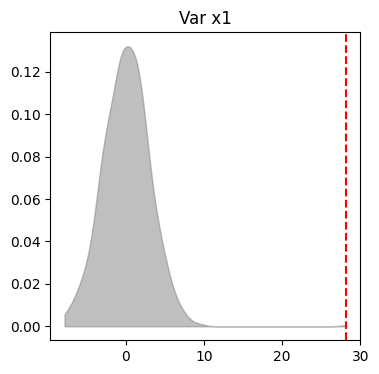

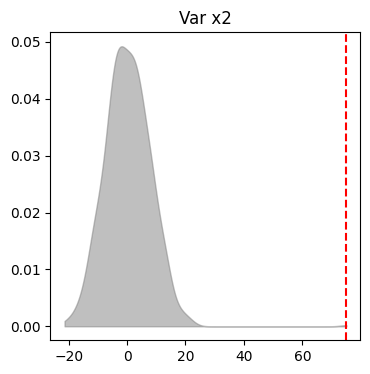

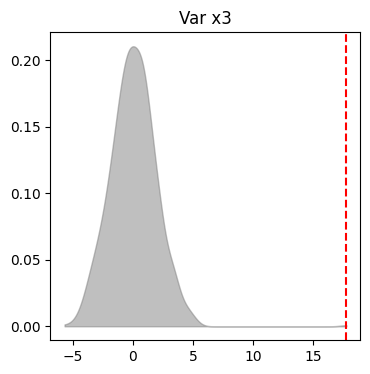

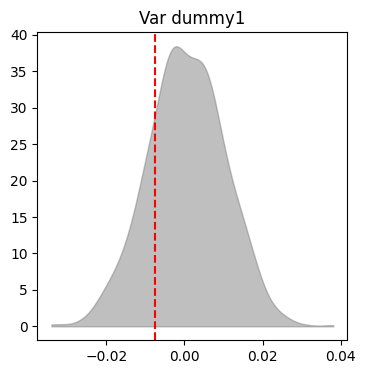

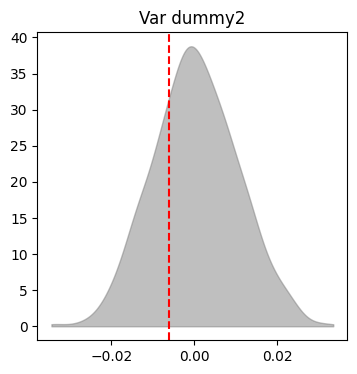

In [7]:
def make_plots():
    
    experiments = pd.read_csv("../files/results/experiments.csv")
    
    for variable in experiments["variable"].drop_duplicates():
        
        plt.figure(figsize=(4, 4))
        sample = experiments[experiments["variable"] == variable].value
        x_min, x_max = sample.min(), sample.max()
        
        bandwidth = 1.06 * sample.std() * sample.size ** (-1 / 5)
        
        current_value = sample.iloc[0]
        
        kde = KernelDensity(kernel = "gaussian", bandwidth=bandwidth).fit(
            sample.values.reshape(-1, 1)
            )
        
        bins = np.linspace(x_min, x_max, 1000)
        log_dens = kde.score_samples(bins.reshape(-1, 1))
        
        plt.fill_between(bins, np.exp(log_dens), alpha=0.5, color="gray")
        plt.axvline(current_value, color="red", linestyle="--")
        plt.title(f"Var {variable}")
        
        plt.show()
        
make_plots()